# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5


---
__Name:__  Ted Pham 
__Class:__ MIDS w261 (Section 3)     
__Email:__  tedapham@iSchool.Berkeley.edu     
__StudentId__  3032588560    __End of StudentId__     
__Week:__   6

__NOTE:__ please replace `1234567` with your student id above      
__Due Time:__ HW is due the Tuesday of the following week by 8AM (West coast time). I.e., Tuesday, Feb 14, 2017 in the case of this homework. 

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as AltaScale's PaaS or on AWS) and is due Tuesday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the Altiscale cluster and will be due Tuesday, Feb 21 by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. 

# 1 Instructions

MIDS UC Berkeley, Machine Learning at Scale   
DATSCIW261 ASSIGNMENT #5.2


### INSTRUCTIONS for SUBMISSIONS 
Follow the instructions for submissions carefully.

Each student has a `HW-<user>` repository for all assignments.   

Push the following to your HW github repo into the master branch:
* Your local HW5 directory. Your repo file structure should look like this:

```
HW-<user>
    --HW3
       |__MIDS-W261-HW-03-<Student_id>.ipynb
       |__MIDS-W261-HW-03-<Student_id>.pdf
       |__some other hw3 file
    --HW4
       |__MIDS-W261-HW-04-<Student_id>.ipynb
       |__MIDS-W261-HW-04-<Student_id>.pdf
       |__some other hw4 file
    etc..
```    

# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
       
    5.4.  [HW5.4](#5.4)    
    5.5.  [HW5.5](#5.5)    
    5.6.  [HW5.6](#5.6)    
    5.7.  [HW5.7](#5.7)    
    5.8.  [HW5.8](#5.8)    
    5.9.  [HW5.9](#5.9)    
   

<a name="5.4"></a> 
# PHASE 2
----------

# HW 5.4   
## Full-scale experiment on Google N-gram data on the CLOUD
__ Once you are happy with your test results __ proceed to generating  your results on the Google n-grams dataset. 

In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
from mrjob.job import MRJob
from mrjob.step import MRStep

# tell matplotlib not to open a new window
%matplotlib inline

# automatically reload modules 
%reload_ext autoreload
%autoreload 2

In [2]:
import os
USER = !whoami
USER = USER[0]
OUTPUT_PATH_BASE = '/user/{USER}'.format(USER=USER)

In [3]:
print OUTPUT_PATH_BASE

/user/tedapham


In [4]:
import nltk

## 3.  HW5.4.0  <a name="5.4.0"></a> Run systems tests on the CLOUD  (PHASE 2)
[Back to Table of Contents](#TOC)

Repeat HW5.3.0 (using the same small data sources that were used in HW5.3.0) on ** the cloud** (e.g., AltaScale / AWS/ SoftLayer/ Azure). Make sure all tests give correct results! Good luck out there!

In [4]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Overwriting googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


In [5]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Overwriting atlas-boon-systems-test.txt


In [17]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
#import collections as cl

class MRbuildStripes(MRJob):
  

  #START SUDENT CODE531_STRIPES
    SORT_VALUES = True
    #OUTPUT_PROTOCOL = RawProtocol
    def steps(self):
        return [MRStep(mapper = self.mapper_count,
                       reducer = self.reducer_count
                )#,
                #jobconf = {'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                           #'mapreduce.partition.keycomparator.options':'-k1,1'}
               ]
    def mapper_count(self, _,line):
        line = line.strip()
        line = line.split("\t")
        
        #--Get n_gram and count
        n_gram, count = line[0],int(line[1])
        words = n_gram.lower().split()
        
        #--get stripe
        len_stripe = len(words) - 1
        if len_stripe > 0:
            for word1 in words:
                temp = words[:]
                temp.remove(word1)
                #--return keyword and the stripe
                yield word1, dict(zip(temp,[count]*len_stripe))
    
    def reducer_count(self, key, value):
        #-- initialize an empty dict
        stripe = dict()
        
        #-- go through the value generator
        for val in value:
            #-- check on the keys of individual dictionary
            for k in val.keys():
                try:
                    stripe[k] += val[k] #-- try update sum total
                except:
                    stripe[k] = val[k] #-- if not then it's a new key, add that key
            
        yield key,stripe
    
    
  #END SUDENT CODE531_STRIPES
  
if __name__ == '__main__':
    MRbuildStripes.run()

Overwriting buildStripes.py


In [66]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}
!python buildStripes.py \
        -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output
!hadoop fs -cat {OUTPUT_PATH}/* > system_test_stripe.txt
!hadoop fs -rm -r {OUTPUT_PATH}
!cat system_test_stripe.txt


17/10/07 21:20:19 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes.tedapham.20171007.212020.362109
Copying local files to hdfs:///user/tedapham/tmp/mrjob/buildStripes.tedapham.20171007.212020.362109/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2064415689427060469.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.

In [44]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
#import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import OrderedDict

class MRinvertedIndex(MRJob):
    
  #START SUDENT CODE531_INV_INDEX
    
    SORT_VALUES = True

    def steps(self):
        return [MRStep(mapper = self.mapper,
                       reducer = self.reducer
                ),
               MRStep(reducer = self.reducer2)]
    #-- get key and the number of pairs in stripes
    #-- number of pairs is the length of the stripe
    def mapper(self, _,line):
        key, stripe = line.strip().split("\t")
        key = key[1:-1] #-- remove quotation marks
        stripe = eval(stripe)
        yield (key, len(stripe)), stripe.keys()
    
    #-- invert broadcast all word with the same count
    def reducer(self, key_length, stripe_keys):
        key, length = key_length
        for k in itertools.chain.from_iterable(stripe_keys): #--unpack the generator
            yield k,(key,length)
    
    #-- use OrderedDict to remember the insertion order to print out
    def reducer2(self,key,value):
        d = OrderedDict()
        for val in value:
            d[val[0]] = val[1]
        yield key, d
        
        

  #END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run()

Overwriting invertedIndex.py


In [67]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'inverted')
!hadoop fs -rm -r {OUTPUT_PATH}
!python invertedIndex.py \
        -r hadoop system_test_stripe.txt\
        --output-dir={OUTPUT_PATH} \
        --no-output
!hadoop fs -cat {OUTPUT_PATH}/* > system_test_index.txt
!hadoop fs -rm -r {OUTPUT_PATH}
!cat system_test_index.txt

17/10/07 21:22:31 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/inverted' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex.tedapham.20171007.212232.407329
Copying local files to hdfs:///user/tedapham/tmp/mrjob/invertedIndex.tedapham.20171007.212232.407329/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1708065807751781846.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altis

In [63]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
#import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys

class MRsimilarity(MRJob):



  #--START SUDENT CODE531_SIMILARITY--#
    SORT_VALUES = True
    #OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [MRStep(mapper = self.mapper,
                       #combiner = self.combiner,
                       reducer = self.reducer
                ),
               MRStep(mapper=self.mapper_similarity,
                     reducer=self.reducer_similarity,
                     jobconf = {'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                'mapreduce.partition.keycomparator.options': '-k1,1nr'}
                    )
               ]
    #-- get key and the number of pairs in stripes
    #-- number of pairs is the length of the stripe
    def mapper(self, _,line):
        key, stripe = line.strip().split("\t")
        #key = key[1:-1] #--Ignore quotation marks
        stripe = eval(stripe)
        #--Get sorted key
        sorted_keys = sorted(stripe.keys())
        
        length = len(sorted_keys)
        
        #-- if length of stripe is 1, cannot create pair
        if length >1 :
            for i in range(length - 1):
                for j in range(i+1,length):
                    pair = str(sorted_keys[i])+'-'+str(sorted_keys[j])
                    pair_ind_count = str(stripe[sorted_keys[i]]) + ',' + \
                                     str(stripe[sorted_keys[j]])
                    output_key = pair + ',' + pair_ind_count
                    yield output_key,1 # yield word1-word2,count1,count2,1
    
    def reducer(self,key,value):
        yield key,sum(value) # yield word1-word2,count1,count2 count_occurence
        
    def mapper_similarity(self,key,co_count):
        
        pair,count1,count2 = key.split(",")
        count1 = int(count1)
        count2 = int(count2)
        co_count = float(co_count)
        
        #-- calculate similarity
        
        jaccard = co_count/(count1 + count2 - co_count)
        cosine = co_count/math.sqrt(count1)/math.sqrt(count2)
        overlap = co_count/min(count1,count2)
        dice = 2*co_count/(count1 + count2)
        
        
        average = (jaccard + cosine + overlap + dice)/4
        
        
        yield average, (pair,jaccard,cosine,overlap,dice)
        
    def reducer_similarity(self,average,similarities):
        
        #average, pair = average_pair
        
        keys = ['pair','jaccard','cosine','overlap','dice']
        for similarity in similarities:
            return_value = collections.OrderedDict()

            for i,s in enumerate(similarity):
                return_value[keys[i]] = s 
            yield average,return_value
    
  #END SUDENT CODE531_SIMILARITY
  
if __name__ == '__main__':
    MRsimilarity.run()

Overwriting similarity.py


In [68]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'similarity')
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarity.py\
        -r hadoop system_test_index.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output
!hadoop fs -cat {OUTPUT_PATH}/* > system_test_similarity.txt
!hadoop fs -rm -r {OUTPUT_PATH}
!cat system_test_similarity.txt

rm: `/user/tedapham/similarity': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.tedapham.20171007.212408.721260
Copying local files to hdfs:///user/tedapham/tmp/mrjob/similarity.tedapham.20171007.212408.721260/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3302731344721001740.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://

## 3.  HW5.4.1 <a name="5.4.1"></a>Full-scale experiment: EDA of Google n-grams dataset (PHASE 2)
[Back to Table of Contents](#TOC)

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.4.1 - A. Longest 5-gram (number of characters)

In [13]:

%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class longest5gram(MRJob):
    
    # START STUDENT CODE 5.4.1.A
    SORT_VALUES = True
    def steps(self):
        return [MRStep(mapper = self.mapper,
                       reducer = self.reducer,
                       jobconf = {#'mapreduce.job.maps': '100',
                                  'mapreduce.job.reduces': '50',
                                  #'mapreduce.map.memory':'4000',
                                  #'mapreduce.reduce.memory':'4000',
                                  'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                  'mapreduce.partition.keycomparator.options': '-k1,1nr'})]
    
    
    def mapper(self, _,line):
        line = line.strip()
        line = line.split("\t")
        
        #--Get n_gram and count
        n_gram = line[0]
        words = n_gram.lower().split()
        
        length = 0
        
        for word in words:
            length += len(word)
       
        yield length, n_gram
        
    def reducer(self, length, n_gram):
        
        yield length, list(n_gram)
    
    # END STUDENT CODE 5.4.1.A
    
if __name__ == '__main__':
    longest5gram.run()

Overwriting longest5gram.py


In [137]:
!python longest5gram.py googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > longest5gram.txt

No configs found; falling back on auto-configuration
Creating temp directory /tmp/longest5gram.tedapham.20171011.002731.354266
Running step 1 of 1...
Streaming final output from /tmp/longest5gram.tedapham.20171011.002731.354266/output...
Removing temp directory /tmp/longest5gram.tedapham.20171011.002731.354266...


In [129]:
!cat longest5gram.txt

29	["A BILL FOR ESTABLISHING RELIGIOUS", "A Circumstantial Narrative of the"]
25	["A Biography of General George"]
24	["A Child's Christmas in Wales"]
23	["A Collection of Fairy Tales"]
22	["A Case Study in Government"]
20	["A Collection of Forms of"]
19	["A Case Study of Limited"]
18	["A Case Study of Female"]
13	["A City by the Sea"]


In [18]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longestfull')
!hadoop fs -rm -r {OUTPUT_PATH}
!python longest5gram.py\
        -r hadoop  hdfs:///user/winegarj/data/full/*.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output
!hadoop fs -cat {OUTPUT_PATH}/* > longest5gramfull.txt
#!hadoop fs -rm -r {OUTPUT_PATH}
#!head -5 longest5gramfull.txt

17/10/10 21:07:51 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/longestfull' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.tedapham.20171010.210751.845438
Copying local files to hdfs:///user/tedapham/tmp/mrjob/longest5gram.tedapham.20171010.210751.845438/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob46115997654993939.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altisc

In [21]:
!hadoop fs -cat {OUTPUT_PATH}/* | sort -n -k1,1nr > longest5gramfull.txt
!hadoop fs -rm -r {OUTPUT_PATH}
!head -10 longest5gramfull.txt

17/10/10 21:15:54 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/longestfull' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/.Trash/Current
155	["AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR", "ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"]
124	["RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR JDDUMHUYPARICOLEVTYPS ILONBUNURT"]
115	["SHIPWRECKIERTGBVCXWQXCE CCCVBNWSESWDFGFIRESNPLM WQRAILROADWRECKSUTRFHJK EXPLOSIONSTRPIQURECEDFG RTYEARTHQUAKECVBNMKDSAW", "RTYEARTHQUAKECVBNMKDSAW VBNEVWVOLCANICERUPTIONS FLOODSCVBEAVALANCHESUYT VBNHURRICANESTORNADOESX TIDALWAVECVBNCYC

In [59]:
#--test
!mapred job -list 

17/10/10 22:10:36 INFO impl.TimelineClientImpl: Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
17/10/10 22:10:37 INFO client.RMProxy: Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
17/10/10 22:10:37 INFO client.AHSProxy: Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
Total jobs:2
                  JobId	     State	     StartTime	    UserName	       Queue	  Priority	 UsedContainers	 RsvdContainers	 UsedMem	 RsvdMem	 NeededMem	   AM info
 job_1506640654827_2061	   RUNNING	 1507673354951	    tedapham	    berkeley	    NORMAL	            123	              0	 188928M	      0M	   188928M	http://rm-ia.s3s.altiscale.com:8088/proxy/application_1506640654827_2061/
 job_1506640654827_1975	   RUNNING	 1507661436206	      xiaowu	    berkeley	    NORMAL	             34	              0	  86016M	      0M	    86016M	http://rm-ia.s3s.altiscale.com:8088/proxy/application_1506640654827_1975/


In [60]:
#--test
!mapred job -kill job_1506640654827_2061

17/10/10 22:10:52 INFO impl.TimelineClientImpl: Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
17/10/10 22:10:52 INFO client.RMProxy: Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
17/10/10 22:10:53 INFO client.AHSProxy: Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
Killed job job_1506640654827_2061


## Longest MRJob stats


    RUNNING for 6 min 30s
    Launched map tasks=192
    Launched reduce tasks=50   
    

### HW5.4.1 - B. Top 10 most frequent words 

In [29]:
#--test
!cat googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt

A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

In [35]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):

    
    
    # START STUDENT CODE 5.4.1.B
    SORT_VALUES = True
    def steps(self):
        return [MRStep(mapper = self.mapper,
                      reducer = self.reducer,
                       jobconf = {#'mapreduce.job.maps': '100',
                                  'mapreduce.job.reduces': '50',
                                  #'mapreduce.map.memory':'4000',
                                  #'mapreduce.reduce.memory':'4000',
                                  }),
                MRStep(mapper = self.mapper2,
                       reducer = self.reducer2,
                       jobconf = { 'mapreduce.job.reduces': '50',
                                  'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                  'mapreduce.partition.keycomparator.options': '-k1,1nr'})]
    
    
    def mapper(self, _,line):
        line = line.strip()
        line = line.split("\t")
        stopWords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
                'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
                'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
                'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']
        #--Get n_gram and count
        n_gram, count = line[0],int(line[1])
        words = n_gram.lower().split()
        
        
        for word in words:
            if word not in stopWords:
                yield word, count
        
    def reducer(self, word, counts):
        yield word, sum(counts)
    
    def mapper2(self,word,count):
        yield int(count), word
    
    def reducer2(self,count,word):
        yield count, list(word)
    # END STUDENT CODE 5.4.1.B
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Overwriting mostFrequentWords.py


In [36]:
!python mostFrequentWords.py googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt

No configs found; falling back on auto-configuration
Creating temp directory /tmp/mostFrequentWords.tedapham.20171010.212248.583934
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/mostFrequentWords.tedapham.20171010.212248.583934/output...
123	["fairy", "tales"]
55	["limited"]
604	["case", "study"]
92	["biography", "general", "george"]
116	["forms"]
102	["government"]
62	["circumstantial", "city", "narrative", "sea"]
239	["collection"]
447	["female"]
59	["bill", "establishing", "religious"]
1099	["child's", "christmas", "wales"]
Removing temp directory /tmp/mostFrequentWords.tedapham.20171010.212248.583934...


**RUN ON FULL DATA SET with 50 Reducers**

In [46]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'frequestest')
!hadoop fs -rm -r {OUTPUT_PATH}
!python mostFrequentWords.py\
        -r hadoop hdfs:///user/winegarj/data/full/*.txt\
        --output-dir={OUTPUT_PATH} \
        --no-output


rm: `/user/tedapham/frequestest': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords.tedapham.20171010.213000.643556
Copying local files to hdfs:///user/tedapham/tmp/mrjob/mostFrequentWords.tedapham.20171010.213000.643556/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8583705726951652568.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service a

Removing temp directory /tmp/mostFrequentWords.tedapham.20171010.213000.643556...


**Compile output files from 50 reducers**

In [51]:
!hadoop fs -cat {OUTPUT_PATH}/* | sort -n -k1,1nr > mostFrequentWords.txt
!head -10 mostFrequentWords.txt

180195771	["one"]
139313915	["would"]
126853684	["time"]
108486904	["may"]
79528921	["part"]
78780613	["could"]
78089800	["first"]
74978840	["made"]
72793319	["way"]
68693179	["two"]


In [53]:
#--Delete output files
!hadoop fs -rm -r {OUTPUT_PATH}

rm: `/user/tedapham/frequestest': No such file or directory


## Most frequent words MR stats
    

__Step 1:__   

    RUNNING for 4 min, 10 s
    Launched map tasks=190 
    Launched reduce tasks=50

__Step 2:__  

    RUNNING for 1 min, 10 s
    Launched map tasks=50
    Launched reduce tasks=50

### HW5.4.1 - C. 20 Most/Least densely appearing words 

In [61]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

stopWords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
                'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
                'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
                'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']


class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.4.1.C
    SORT_VALUES = True
    def steps(self):
        return [MRStep(mapper = self.mapper,
                      reducer = self.reducer,
                       jobconf = {
                                  'mapreduce.job.reduces': '50'
                                  }),
                MRStep(mapper = self.mapper2,
                       reducer = self.reducer2,
                       jobconf = {'mapreduce.job.reduces': '50',
                                  'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                  'mapreduce.partition.keycomparator.options': '-k1,1nr'})]
    
    
    def mapper(self, _,line):
        line = line.strip()
        line = line.split("\t")
        
        #--Get n_gram and count
        n_gram, count, pages_count = line[0],int(line[1]),int(line[2])
        words = n_gram.lower().split()
        
        
        for word in words:
            if word not in stopWords:
                yield word, (count,pages_count)
        
    def reducer(self, word, counts):
        count = 0
        pages_count = 0
        for count_info in counts:
            count += float(count_info[0])
            pages_count += float(count_info[1])
            
        yield word, count/pages_count
    
    def mapper2(self,word,density):
        yield float(density), word
    
    def reducer2(self,density,word):
        yield density, list(word)
    # END STUDENT CODE 5.4.1.C
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

Overwriting mostLeastDenseWords.py


In [62]:
!python mostLeastDenseWords.py googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt

No configs found; falling back on auto-configuration
Creating temp directory /tmp/mostLeastDenseWords.tedapham.20171010.221314.171817
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/mostLeastDenseWords.tedapham.20171010.221314.171817/output...
1.0358152686145146	["child's", "christmas", "wales"]
1.1262135922330097	["forms"]
1.0333333333333334	["city", "sea"]
1.0	["bill", "case", "circumstantial", "establishing", "female", "government", "limited", "narrative", "religious", "study"]
1.0512820512820513	["fairy", "tales"]
1.0863636363636364	["collection"]
1.0222222222222221	["biography", "general", "george"]
Removing temp directory /tmp/mostLeastDenseWords.tedapham.20171010.221314.171817...


In [63]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'dense')
!hadoop fs -rm -r {OUTPUT_PATH}
!python mostLeastDenseWords.py\
        -r hadoop hdfs:///user/winegarj/data/full/*.txt\
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/tedapham/dense': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostLeastDenseWords.tedapham.20171010.221407.874169
Copying local files to hdfs:///user/tedapham/tmp/mrjob/mostLeastDenseWords.tedapham.20171010.221407.874169/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4500750512675945151.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service add

Removing temp directory /tmp/mostLeastDenseWords.tedapham.20171010.221407.874169...


In [64]:
!hadoop fs -cat {OUTPUT_PATH}/* | sort -n -k1,1nr > mostLeastDenseWords.txt
!echo ------TOP 20 DENSE WORDS ----------------
!head -20 mostLeastDenseWords.txt
!echo ------BOTTOM 20 DENSE WORDS--------------
!tail -20 mostLeastDenseWords.txt

------TOP 20 DENSE WORDS ----------------
11.557291666666666	["xxxx"]
8.0741599073001158	["blah"]
7.5333333333333332	["nnn"]
6.2017491314244637	["na"]
4.921875	["oooooooooooooooo"]
4.8543057272352703	["nd"]
4.5116279069767442	["llll"]
4.169650013358269	["oooooo"]
3.8586371934672128	["ooooo"]
3.7624521072796937	["lillelu"]
3.5769230769230771	["pfeffermann", "madarassy"]
3.5600000000000001	["meteoritical"]
3.5	["xxxxxxxx"]
3.2290388548057258	["beep"]
3.1886792452830188	["latha"]
2.9191176470588234	["iyengar"]
2.8250000000000002	["counterfeiteth"]
2.8198198198198199	["nonmorular", "nonsquamous"]
2.7916257022471909	["ft"]
2.7317370129870131	["nn"]
------BOTTOM 20 DENSE WORDS--------------
1.0000717257208436	["resplendent"]
1.0000711288142827	["surged"]
1.000070771408351	["severities"]
1.0000694782185784	["sparked"]
1.0000680087051144	["cannonade"]
1.0000661419406045	["stoutly"]
1.0000650258477746	["enthusiastically"]
1.0000617322056917	["broached"]
1.000058186896311	["tiptoed"]
1.000055352

1.0	["dzitas", "zwitterionic", "aaslh", "zwecken", "abbayes", "zuccaro", "zondcrvan", "zonae", "abenaki", "zeugnis", "abfalls", "zeke", "abidings", "zeitgenossischen", "zebras", "zazzera", "abigail's", "abjectio", "abma", "zalmon", "zaharrof", "yuletide", "yronne", "yram", "yoursell", "abowt", "abrupte", "yokuts", "yodel", "ynow", "ymha", "yis", "yfl", "yezidis", "yeve", "yermak", "yeobright", "yechiel", "yce", "yathreb", "yataghan", "yasya", "yaobang's", "yanez", "xliv", "abuleilah", "wyter", "wycks", "wyatt's", "wus", "wrecker's", "wrappage", "worthi", "worstede", "abutted", "worldconspiracy", "woolson's", "woolcomber", "woodsface", "woodley", "woodenness", "woodburytype", "wolverine", "abyla", "acabada", "accolti", "wochenschrift", "wite", "witcheries", "wisshe", "accouchement", "accusive", "wiscon", "wirklich", "acerbity", "acftu", "wingcovers", "windowed", "windflower", "willingliest", "acheronta", "wilbe", "achromatopsia", "achten", "wieviel", "acqueentence", "wiedergabe", "wider

 "togeather", "toddles", "tna", "titihoya", "titaness", "tisnacq", "tisiphone", "tiresomeness", "tippins", "tingitana", "timebecause", "tilbury's", "tiirlin's", "tiefenwanderungen", "tidily", "ticklish", "thwartings", "thunked", "thrise", "thought's", "thorwaldsen's", "thls", "thistledown", "thinnish", "thesiger's", "theseus's", "thermiques", "theriaca", "therfore", "therethrough", "theogonies", "theodatus", "thamir", "thalaba", "tgr", "teyyam", "tetradrachm", "teterrima", "testimonys", "testimonio", "terrifies", "terminentur", "tepping", "tepaske", "tepanecs", "tenudo", "tentasse", "templeman", "tempestuously", "tellus", "tellson", "telangiectasies", "technica", "teasers", "tdot", "tchambuli", "taynted", "tawe", "taung", "tatua", "tat's", "tastebuds", "tartus", "tarpeiam", "tarheel", "tantos", "tanga", "tamarinds", "tamarensis", "takasako", "taiarboo", "tahitians", "taftsness", "tacts", "taborites", "tablespaces", "syphilitics", "syntax's", "synonymousness", "synonimes", "syncopation"

In [65]:
!hadoop fs -rm -r {OUTPUT_PATH}

17/10/10 22:30:18 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/dense' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/.Trash/Current


## Word Density MR STATS    

__Step 1:__   

    RUNNING for 7 min, 30 s
    Launched map tasks=190 
    Launched reduce tasks=50

__Step 2:__  

    RUNNING for 1 min, 6s
    Launched map tasks=50
    Launched reduce tasks=50

### HW5.4.1 - D. Distribution of 5-gram sizes (character length)

In [68]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep



class distribution(MRJob):
    
    # START STUDENT CODE 5.4.1.D
    SORT_VALUES = True
    def steps(self):
        return [MRStep(mapper = self.mapper,
                       reducer = self.reducer,
                       jobconf = {'mapreduce.job.reduces': '50',
                                  'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                  'mapreduce.partition.keycomparator.options': '-k1,1nr'})]
    
    def mapper(self, _,line):
        line = line.strip()
        line = line.split("\t")
        
        #--Get n_gram and count
        n_gram,count = line[0], int(line[1])
        words = n_gram.lower().split()
        
        n_gram_length = 0
        
        for word in words:
            n_gram_length += len(word)
       
        yield n_gram_length, count
    
        
    def reducer(self, length, count):
        yield length, sum(count)
    
    #def reducer
    # END STUDENT CODE 5.4.1.D
    
if __name__ == '__main__':
    distribution.run()

Overwriting distribution.py


In [62]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distribution')
!hadoop fs -rm -r {OUTPUT_PATH}
!python distribution.py\
        -r hadoop hdfs:///user/winegarj/data/full/*.txt\
        --output-dir={OUTPUT_PATH} \
        --no-output

17/10/11 19:42:07 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/distribution' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.tedapham.20171011.194207.916655
Copying local files to hdfs:///user/tedapham/tmp/mrjob/distribution.tedapham.20171011.194207.916655/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob5208430577580125897.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.alt

In [77]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distribution')
!hadoop fs -rm -r {OUTPUT_PATH}
!python distribution.py\
        -r hadoop hdfs:///user/winegarj/data/full/*.txt\
        --output-dir={OUTPUT_PATH} \
        --no-output

17/10/10 22:57:42 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/distribution' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.tedapham.20171010.225743.060584
Copying local files to hdfs:///user/tedapham/tmp/mrjob/distribution.tedapham.20171010.225743.060584/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1339593400646475006.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.alt

In [78]:
!hadoop fs -cat {OUTPUT_PATH}/* | sort -n -k1,1nr > distribution.txt
!head -20 distribution.txt

155	182
124	92
115	148
102	90
99	91
87	155
86	84
85	92
82	91
80	421
79	51
78	95
75	83
72	157
71	87
69	182
68	334
67	292
66	375
65	230


In [82]:
!cat distribution.txt

155	182
124	92
115	148
102	90
99	91
87	155
86	84
85	92
82	91
80	421
79	51
78	95
75	83
72	157
71	87
69	182
68	334
67	292
66	375
65	230
64	211
63	365
62	460
61	1263
60	1449
59	2094
58	2544
57	4984
56	4388
55	8653
54	14919
53	22210
52	23339
51	58593
50	64675
49	94986
48	162867
47	230726
46	373875
45	551091
44	802590
43	1175703
42	1603291
41	2600568
40	3568517
39	5169492
38	7704330
37	10971218
36	15560400
35	22259683
34	31113761
33	44027088
32	60137979
31	84419521
30	115556130
29	155555837
28	205588578
27	269584490
26	345711670
25	433764087
24	530179866
23	636987536
22	739311284
21	826976077
20	894422079
19	921800718
18	903382557
17	825593117
16	692585590
15	519029171
14	327102659
13	171644826
12	70338372
11	23247701
10	5950911
9	888866
8	114018
7	31532
6	5740
5	14140


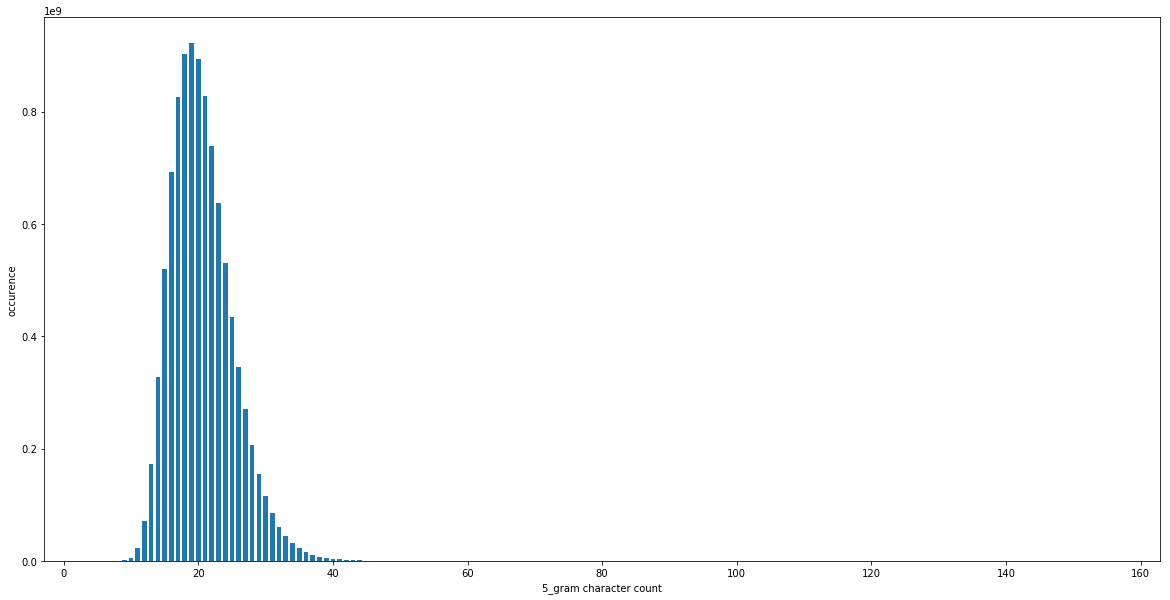

In [109]:
import matplotlib.pyplot as plt

f = open('distribution.txt')

n_gram_length = []
occurence = []
for line in f.readlines():
    line = line.strip()
    length, count = line.split("\t")
    n_gram_length.append(int(length))
    occurence.append(int(count))
f.close()

plt.figure(figsize=(20,10))
plt.bar(n_gram_length,occurence, width = 0.7)
plt.xlabel('5_gram character count')
plt.ylabel('occurence')

In [91]:
map(math.log,[4,3])

[1.3862943611198906, 1.0986122886681098]

**Log-Log Plot**
indicative of power law

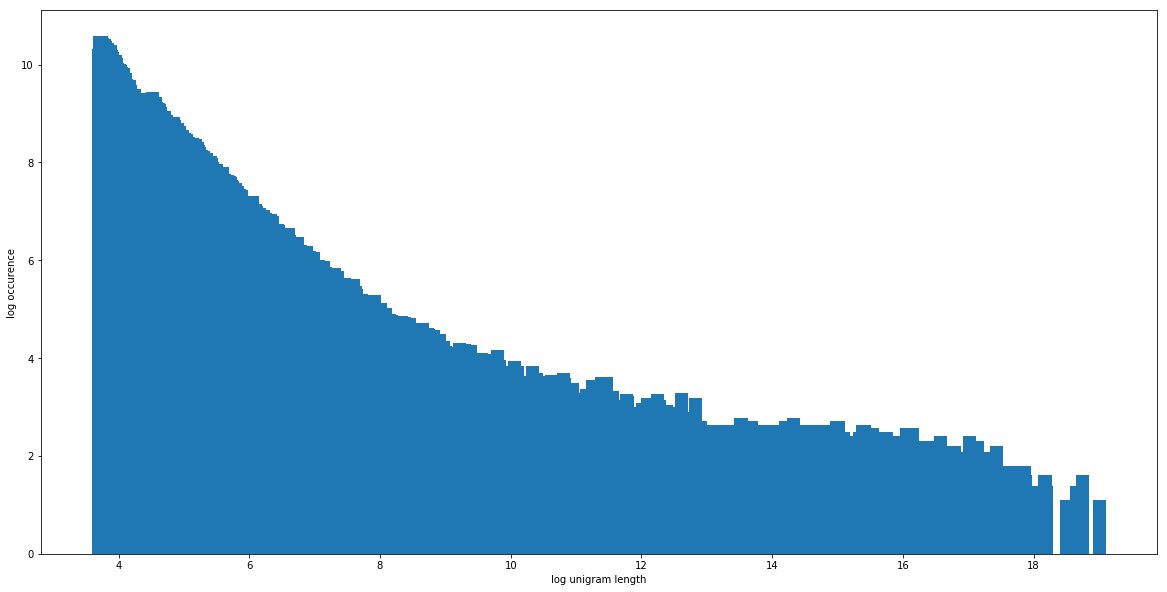

In [28]:
f = open('mostFrequentWords.txt')
import math
n_gram_length = []
occurence = []
for line in f.readlines():
    line = line.strip()
    length, count = line.split("\t")
    n_gram_length.append(float(length))
    occurence.append(float(len(count)-4))
f.close()

plt.figure(figsize=(20,10))
plt.bar(map(math.log,n_gram_length),map(math.log,occurence), width = 0.2)
plt.xlabel('log unigram length')
plt.ylabel('log occurence')

## Distribution MRJob stats

__Step 1:__ 

    RUNNING for 5min8s  
    Launched map tasks=191
    Launched reduce tasks=50  
    
__Step 2:__  

    RUNNING for 1min10s   
    Launched map tasks=50
	Launched reduce tasks=50  

## 3.  HW5.4.2 <a name="5.4.2"></a>OPTIONAL Question: log-log plots (PHASE 2)
[Back to Table of Contents](#TOC)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

## 3.  HW5.5  <a name="5.5"></a> Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3 plus some preprocessing)   (Phase 2)
[Back to Table of Contents](#TOC)

For the remainder of this assignment please feel free to eliminate stop words from your analysis

>There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
 stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,0000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

#### Design notes for TASK (1)
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for TASK (2).

#### Design notes for _TASK (2)_
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

**STEP 1**

*Most Frequent Words*
This was already solved in 5.4.1B. Now we just need to get the top 10,000 words.
Write extractWords to get the required 1000 features.

In [5]:
%%writefile extractWords.py
def extractWords(filename):
    words = []
    f = open(filename)
    line_number = 0
    for line in f.readlines():
        line_number += 1
        if line_number <=10000 and line_number >= 9001:
            words.append(line.strip().split("\t")[1][2:-2])
    f.close()
    return words
        

Overwriting extractWords.py


*Build Stripes for 1000 features*

In [63]:
%%writefile build_stripe.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
#import re
import mrjob
#import json
#from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep



class MRbuildStripes(MRJob):
  

  #START SUDENT CODE531_STRIPES
    SORT_VALUES = True
    #OUTPUT_PROTOCOL = RawProtocol
    
 
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                       mapper = self.mapper_count,
                       reducer = self.reducer_count,
                       jobconf = {'mapreduce.job.reduces': '50'})
               ]
    
    def mapper_init(self):
        
        def extractWords(filename):
            words = []
            f = open(filename)
            line_number = 0
            for line in f.readlines():
                line_number += 1
                if line_number <=10000 and line_number >= 9001:
                    words.append(line.strip().split("\t")[1][2:-2])
            f.close()
            return words
        self.words = extractWords('mostFrequentWords.txt')
        
    def mapper_count(self, _,line):
        line = line.strip()
        line = line.split("\t")
        
        #--Get n_gram and count
        n_gram, count = line[0],int(line[1])
        words = n_gram.lower().split()
        
        #--get stripe
        
        for word1 in words:

            if word1 in self.words:
             
                temp = [word2 for word2 in words if word2 in self.words and word2 != word1]

            #--return keyword and the stripe
                if len(temp) > 0:
                    yield word1, dict(zip(temp,[count]*len(temp)))
    
    def reducer_count(self, key, value):
        #-- initialize an empty dict
        stripe = dict()
        
        #-- go through the value generator
        for val in value:
            #-- check on the keys of individual dictionary
            for k in val.keys():
                try:
                    stripe[k] += val[k] #-- try update sum total
                except:
                    stripe[k] = val[k] #-- if not then it's a new key, add that key
            
        yield key,stripe
    
    
  #END SUDENT CODE531_STRIPES
  
if __name__ == '__main__':
    MRbuildStripes.run()

Overwriting build_stripe.py


In [58]:
!python build_stripe.py test.txt --file mostFrequentWords.txt

No configs found; falling back on auto-configuration
Creating temp directory /tmp/build_stripe.tedapham.20171011.193920.186123
Running step 1 of 1...
Streaming final output from /tmp/build_stripe.tedapham.20171011.193920.186123/output...
"rector"	{"elector": 55}
"positioned"	{"notify": 55}
"elector"	{"rector": 55}
"notify"	{"positioned": 55}
Removing temp directory /tmp/build_stripe.tedapham.20171011.193920.186123...


In [59]:
%%writefile test.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A conversed by the Sea	62	60	49
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative unquestionably the	62	62	50
A City by the Sea	62	60	49
A elector rector of Limited	55	55	43
A positioned notify of Limited	55	55	43

Overwriting test.txt


In [60]:
extractWords.extractWords('mostFrequentWords.txt')

['adduced',
 'proclaim',
 'interpreter',
 'roses',
 'accumulate',
 'doings',
 'specifications',
 'flashed',
 'revealing',
 'thereafter',
 'lawn',
 'bourgeois',
 'experiencing',
 'pathological',
 'alveolar',
 'unusually',
 'troop',
 'parked',
 'fiery',
 'implementing',
 'insoluble',
 'wording',
 'contradict',
 'buffer',
 'damned',
 'hungary',
 'exhaustion',
 'infringement',
 'essentials',
 'dew',
 'coats',
 'ushered',
 'mast',
 'whither',
 'spoil',
 'altering',
 'unfortunately',
 'agrarian',
 'guides',
 'negation',
 'yielding',
 'sequences',
 'maiden',
 'flourish',
 'traitor',
 'spur',
 'thames',
 'pancreas',
 'deficiencies',
 'inherit',
 'franklin',
 'flush',
 'holocaust',
 'unstable',
 'episodes',
 'redeem',
 'stationary',
 'pilgrims',
 'intrusted',
 'wasting',
 'lobes',
 'dictate',
 'refinement',
 'capitol',
 'articulation',
 'brand',
 'conqueror',
 'inferiority',
 'suggestive',
 'serpent',
 'sued',
 'overlooking',
 'genre',
 'repentance',
 'originate',
 'silly',
 'impatience',
 'cen

In [64]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'stripes')
!hadoop fs -rm -r {OUTPUT_PATH}
!python build_stripe.py\
        -r hadoop hdfs:///user/winegarj/data/full/*.txt\
        --file mostFrequentWords.txt\
        --output-dir={OUTPUT_PATH} \
        --no-output

17/10/11 19:49:38 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/stripes' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/tedapham/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/build_stripe.tedapham.20171011.194939.510698
Copying local files to hdfs:///user/tedapham/tmp/mrjob/build_stripe.tedapham.20171011.194939.510698/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob5820677118067044789.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscal

In [66]:
!hadoop fs -cat {OUTPUT_PATH}/* > 1000stripes.txt

In [67]:
!head -10 1000stripes.txt

"administering"	{"wholesome": 60, "enforcing": 734, "loosely": 52, "implementing": 500, "appellate": 71, "workplace": 90, "designing": 45, "rite": 135, "punishments": 53, "oaths": 402}
"arthritis"	{"viral": 389, "articular": 401, "skeletal": 66, "cartilage": 353, "congestive": 40, "anemia": 69}
"atrium"	{"perimeter": 54, "mitral": 623, "drained": 145, "originate": 120, "positioned": 583, "cava": 2158, "dilatation": 753, "foramen": 236, "groove": 114, "lobby": 44, "valves": 66}
"banquet"	{"recreation": 66, "maiden": 84, "dishes": 142, "unnatural": 174, "overcoming": 613, "plentiful": 70, "preside": 238, "au": 245, "delights": 40, "magnificence": 57, "coronation": 179, "halls": 62, "hood": 75}
"chanced"	{"spy": 108, "strokes": 46, "swords": 92, "superstition": 101, "appointments": 85, "advertisement": 59}
"complexion"	{"pink": 597, "hue": 115, "dispositions": 103, "withheld": 40, "roses": 136, "altering": 59, "unnatural": 40, "warmer": 166, "temperament": 69, "freshness": 178, "skins": 7

*Compute Inverted Index for 1000 Stripes*

In [20]:
#--Get Inverted Index
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'1000inverted')
!hadoop fs -rm -r {OUTPUT_PATH}
!python invertedIndex.py \
        -r hadoop 1000stripes.txt\
        --output-dir={OUTPUT_PATH} \
        --no-output
!hadoop fs -cat {OUTPUT_PATH}/* > 1000index.txt
!hadoop fs -rm -r {OUTPUT_PATH}
!head -20 1000index.txt

rm: `/user/tedapham/1000inverted': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex.tedapham.20171011.232406.531387
Copying local files to hdfs:///user/tedapham/tmp/mrjob/invertedIndex.tedapham.20171011.232406.531387/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6229294774902963463.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address:

*Calculate Similarities using code from 5.4.0*

In [21]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'1000similarity')
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarity.py\
        -r hadoop 1000index.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output
!hadoop fs -cat {OUTPUT_PATH}/* > 1000similarity.txt
!hadoop fs -rm -r {OUTPUT_PATH}
!head -20 1000similarity.txt

rm: `/user/tedapham/1000similarity': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.tedapham.20171011.233414.237098
Copying local files to hdfs:///user/tedapham/tmp/mrjob/similarity.tedapham.20171011.233414.237098/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6641194564113422883.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: htt

*Pretty Print*

In [76]:

import json

print '—'*110
print "synonyms from 1000 features"
print '—'*110
print "{0:>15} |{1:>30} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
      "average", "pair", "cosine", "dice", "overlap", "jaccard")
print '-'*110

f = open("1000similarity.txt")
linecount = 0
for line in f.readlines():
    linecount += 1
    if linecount <= 100:
        line = line.strip()
        avg,stripe = line.split("\t")
        stripe = eval(stripe)

        print "{0:>15f} |{1:>30} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
          float(avg), stripe['pair'], float(stripe['cosine']), float(stripe['dice']), float(stripe['overlap']), float(stripe['jaccard']))
    else:
        break
f.close()

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
synonyms from 1000 features
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
        average |                          pair |         cosine |           dice |        overlap |        jaccard
--------------------------------------------------------------------------------------------------------------
       0.602671 |                concede-deduce |       0.577350 |       0.500000 |       1.000000 |       0.333333
       0.537500 |               deduce-hampered |       0.500000 |       0.400000 |       1.000000 |       0.250000
       0.537500 |             confuse-formative |       0.500000 |       0.400000 |       1.000000 |       0.250000
       0.512821 |                       est-qui |       0.555556 |       0.555556 |       0.555556 |       0.384615
       0.495137 |          acknowledgments-ieee |       0.4

### HW5.6 Evaluation of synonyms that you discovered

In [17]:
# get number of line
!wc -l 1000similarity.txt

63179 1000similarity.txt


In [24]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk

#--Download Wordnet
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []


f = open("1000similarity.txt")
linecount = 0 #also adjusted
for line in f.readlines():
    linecount += 1
    if linecount <= 1000: #get top 1000 pairs only

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst = lisst.values() #--adjusted the code
        lisst.append(avg)
        top1000sims.append(lisst)
    else:
        break
f.close()

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    #print pair
    words = pair.split("-")
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0].strip())
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1].strip())

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(np.unique(np.array(not_in_wordnet)))
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in np.unique(np.array(not_in_wordnet)):
    print synonyms(word),word


[nltk_data] Downloading package wordnet to /home/tedapham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 3 out of top 1000
Number of words without synonyms: 17
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.00234806629834
Recall		0.000701071488364
F1		0.000941737820191
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] antonio
[] brother's
[] buenos
[] cava
[] doctor's
[] fide
[] hague
[] ieee
[] jane
[] mind's
[] qui
[] sabha
[] spake
[] squamous
[] sri
[] whoever
[] zur
